In [6]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

from scipy.stats import mannwhitneyu, binom
rstest_twosided = lambda x, y : mannwhitneyu(x, y, alternative='two-sided')

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D
from mesostat.stat.permtests import difference_test

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import cluster_dist_matrix, test_quantity


%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-neuro/chernysheva-tmaze-analysis-2020
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
# params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
# params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/home/alyosha/Desktop/maria/dff/'
# params['root_path_deconv'] = '/home/alyosha/Desktop/maria/deconv/'
params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [8]:
dataDB = BehaviouralNeuronalDatabase(params)

In [9]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [10]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# Temporal Structure

Questions:
1. Do temporal features predict modality
2. Relationship structure

Predictors:
* mean by cell, variance of mean by cell
* temporal_order by cell -> (cell-wise test, proxy via tsne)
* legendre basis by cell -> (cell-wise base wise test, proxy via tsne)
* var(temp_order) by trial by cell -> (cell-wise test, proxy via tsne)
* var(legendre_basis) by trial by cell -> (cell-wise test, proxy via tsne)
* binary_orderability
    - permutation test on directly on ABO
    - (maybe) significance matrix for each link, test counting (prob. via permutation test)
* sequencability -> proxy via tsne (count if cell does approx 1 spike)

Variations:
* Time : [Stretched, Min-cropped]
* Cells : [All, Significantly active]

## 1.1 Temporal Mean by cell

In [19]:
def count_significant_cells(dataDB, queryDict, selector, condition, metricName, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, metricName, "pr", selector, {})]
            
        nCells = dataDB.get_nchannel(mousename, queryDict['datatype'])
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"]))

In [38]:
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "deconv", "direction" : "R"}
count_significant_cells(dataDB, queryDict, {"interval" : 7}, "performance", "ord_mean")

No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,2,88,0.7
1,m061,2,46,1.1
2,m065,5,83,2.8
3,m066,0,47,-0.0
4,m067,0,49,0.0
5,m068,0,28,-0.0


## 1.2 Variance of Temporal Mean by cell

In [49]:
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "deconv", "direction" : "R"}

for iInterv in range(5, 8):
    print("Interval", iInterv)
    count_significant_cells(dataDB, queryDict, {"interval" : iInterv}, "performance", "ord_mean", proxyFunc=np.std, nResample=1000)

Interval 5
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,1,88,0.2
1,m061,1,46,0.4
2,m065,3,83,1.3
3,m066,0,47,-0.0
4,m067,2,49,1.1
5,m068,1,28,0.6


Interval 6
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,0,88,0.0
1,m061,1,46,0.4
2,m065,1,83,0.2
3,m066,0,47,-0.0
4,m067,1,49,0.4
5,m068,0,28,-0.0


Interval 7
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,0,88,0.0
1,m061,1,46,0.4
2,m065,6,83,3.7
3,m066,0,47,-0.0
4,m067,1,49,0.4
5,m068,0,28,-0.0


## 1.3 Legendre Basis by cell

In [50]:
def count_significant_cells_legendre(dataDB, queryDict, selector, condition, basisIdx, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, 'temporal_basis', "pr", selector, {})[:,:,basisIdx]]
            
        nCells = dataDB.get_nchannel(mousename, queryDict['datatype'])
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"]))

In [57]:
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "deconv", "direction" : "R"}

for iInterv in range(5, 8):
    print("Interval", iInterv)
    count_significant_cells_legendre(dataDB, queryDict, {"interval" : iInterv}, "performance", 2)

Interval 5
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,1,88,0.2
1,m061,1,46,0.4
2,m065,0,83,0.0
3,m066,0,47,-0.0
4,m067,2,49,1.1
5,m068,0,28,-0.0


Interval 6
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,0,88,0.0
1,m061,0,46,0.0
2,m065,1,83,0.2
3,m066,1,47,0.4
4,m067,0,49,0.0
5,m068,0,28,-0.0


Interval 7
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,0,88,0.0
1,m061,1,46,0.4
2,m065,2,83,0.7
3,m066,0,47,-0.0
4,m067,0,49,0.0
5,m068,0,28,-0.0


In [63]:
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "deconv", "direction" : "R"}

for iInterv in range(5, 8):
    print("Interval", iInterv)
    count_significant_cells_legendre(dataDB, queryDict, {"interval" : iInterv}, "performance", 2, proxyFunc=np.std)

Interval 5
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,0,88,0.0
1,m061,1,46,0.4
2,m065,0,83,0.0
3,m066,0,47,-0.0
4,m067,0,49,0.0
5,m068,1,28,0.6


Interval 6
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,3,88,1.2
1,m061,2,46,1.1
2,m065,2,83,0.7
3,m066,1,47,0.4
4,m067,1,49,0.4
5,m068,0,28,-0.0


Interval 7
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,3,88,1.2
1,m061,1,46,0.4
2,m065,4,83,2.0
3,m066,3,47,1.9
4,m067,0,49,0.0
5,m068,1,28,0.6


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,5,440,0.3
1,m061,1,230,0.0
2,m065,6,415,0.6
3,m066,0,235,-0.0
4,m067,4,245,0.6
5,m068,4,140,1.3


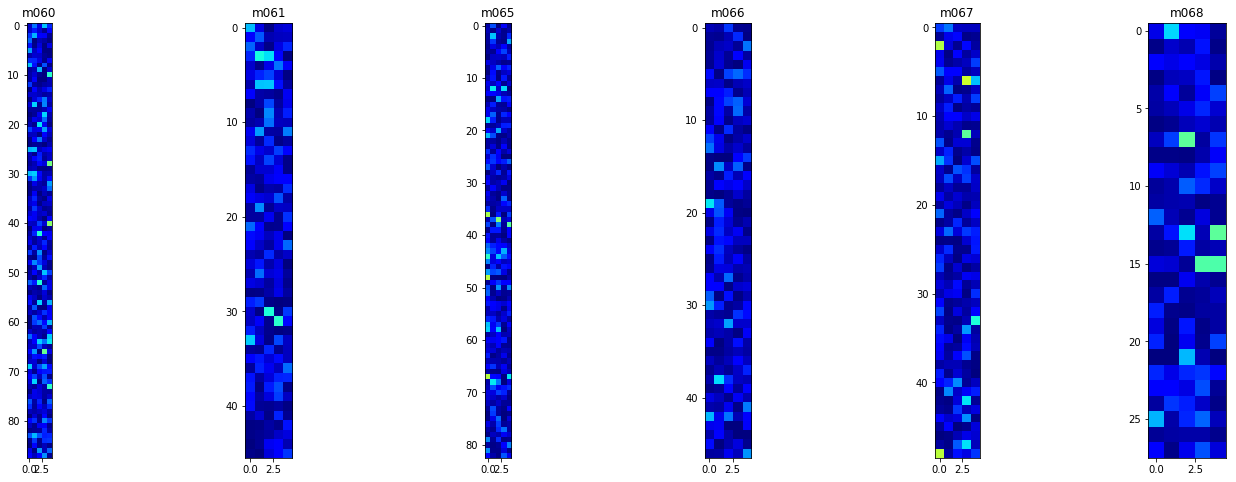

In [27]:
def test_mean_legendre(dataDB, queryDict, selector, condition, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 8))
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, "temporal_basis", "rp", selector, {})]
            
        nTrialsA, nCells, nBasis = means[0].shape
        nTrialsB, nCells, nBasis = means[1].shape
        
        meansA = means[0].reshape((nTrialsA, nCells*nBasis)).T
        meansB = means[1].reshape((nTrialsB, nCells*nBasis)).T
        
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(meansA, meansB, pval)
        
        pValByCellReshaped = np.array(pValByCell).reshape((nCells, nBasis))
        negLogPValByCell = -np.log10(pValByCellReshaped)
        
        ax[iMouse].imshow(negLogPValByCell, vmin=0, vmax=5, cmap="jet")
        ax[iMouse].set_title(mousename)
            
        mouseResults += [[mousename, nCellSignificant, nCells*nBasis, negLogPValPop]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "pvalPopulation"]))
    plt.show()
    
queryDict = {"datatype" : "deconv", "performance" : "Correct"}
# queryDict = {"datatype" : "deconv", "direction" : "R"}
test_mean_legendre(dataDB, queryDict, {"interval" : 7}, "direction")

## 1.4 Variance of Legendre Basis by cell

No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,121,440,132.4
1,m061,28,230,20.9
2,m065,155,415,193.4
3,m066,41,235,36.7
4,m067,67,245,73.6
5,m068,49,140,60.2


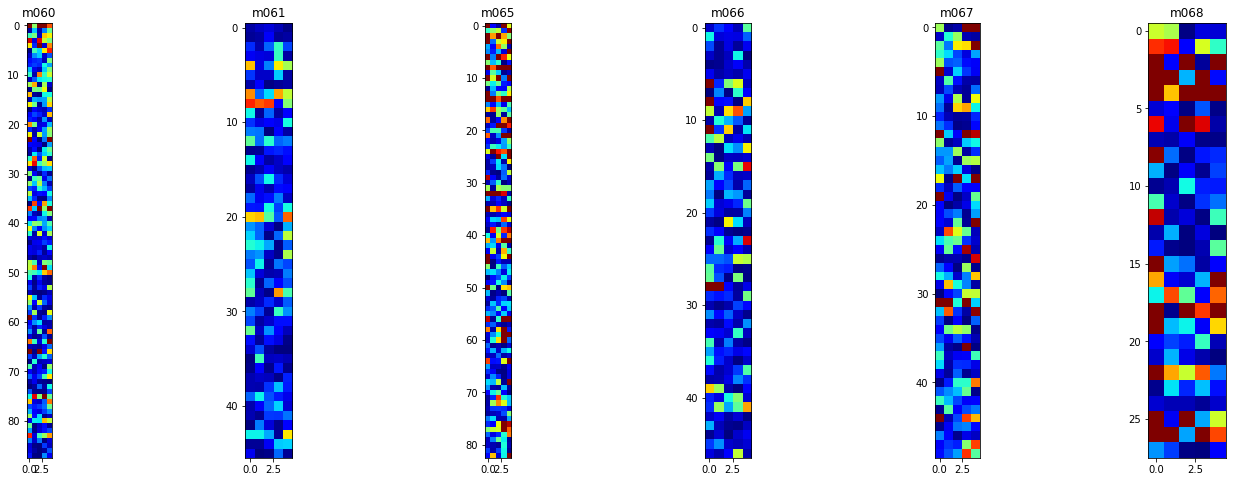

In [36]:
def test_var_legendre(dataDB, queryDict, selector, condition, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 8))
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        variances = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            metric = metric_by_selector(dataDB, queryDictCond, "temporal_basis", "rp", selector, {})
            mu = np.mean(metric, axis=0)
            variances += [(metric - mu)**2]
                        
        nTrialsA, nCells, nBasis = variances[0].shape
        nTrialsB, nCells, nBasis = variances[1].shape
        
        variancesA = variances[0].reshape((nTrialsA, nCells*nBasis)).T
        variancesB = variances[1].reshape((nTrialsB, nCells*nBasis)).T
        
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(variancesA, variancesB, pval)
        
        pValByCellReshaped = np.array(pValByCell).reshape((nCells, nBasis))
        negLogPValByCell = -np.log10(pValByCellReshaped)
        
        ax[iMouse].imshow(negLogPValByCell, vmin=0, vmax=5, cmap="jet")
        ax[iMouse].set_title(mousename)
            
        mouseResults += [[mousename, nCellSignificant, nCells*nBasis, negLogPValPop]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "pvalPopulation"]))
    plt.show()
    
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "deconv", "direction" : "R"}
test_var_legendre(dataDB, queryDict, {"interval" : 5}, "performance")

In [ ]:
Performance(L)
    - (I5) 
Direction
    - (I5) All mice multiple cells significantly different 
    - (I6) M60, M65, M68 multiple cells significantly different
    - (I7) M60, M65, M68 a few cells significantly different


Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


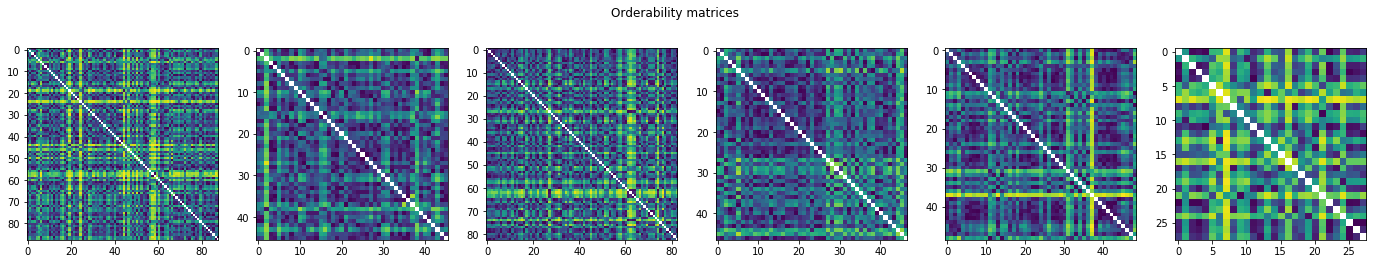

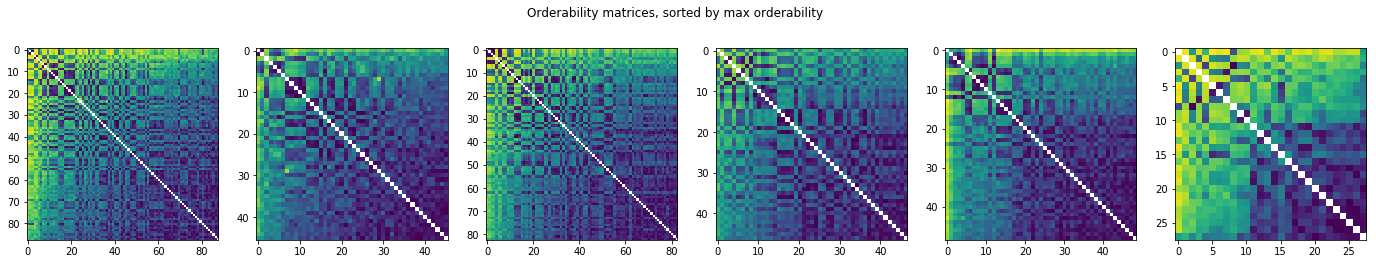

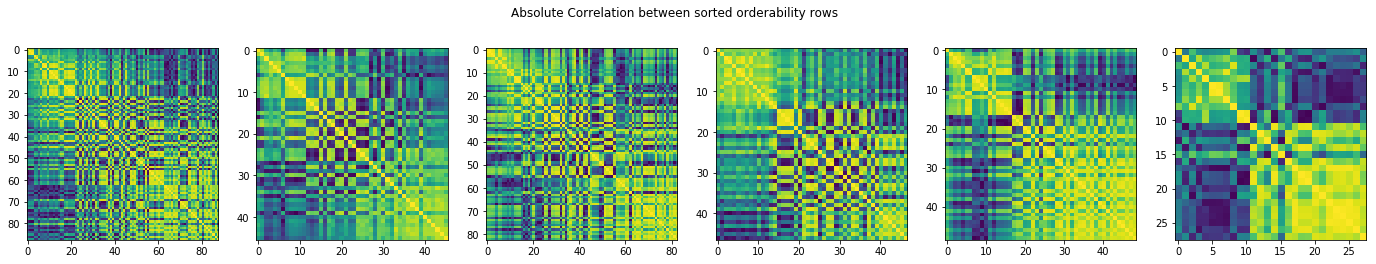

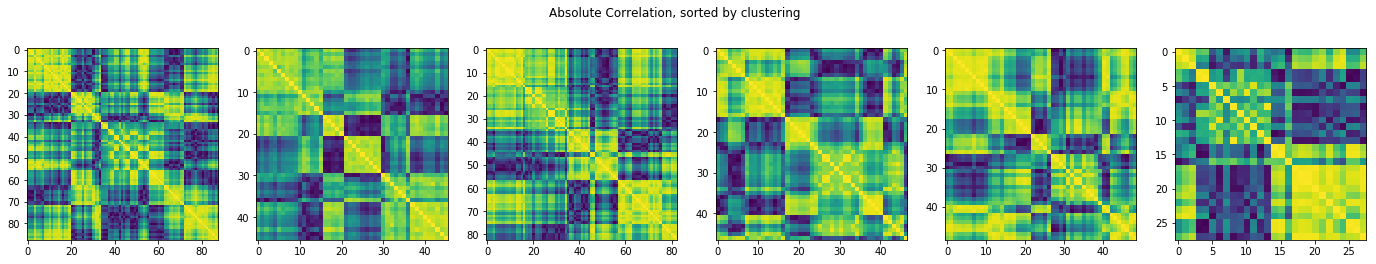

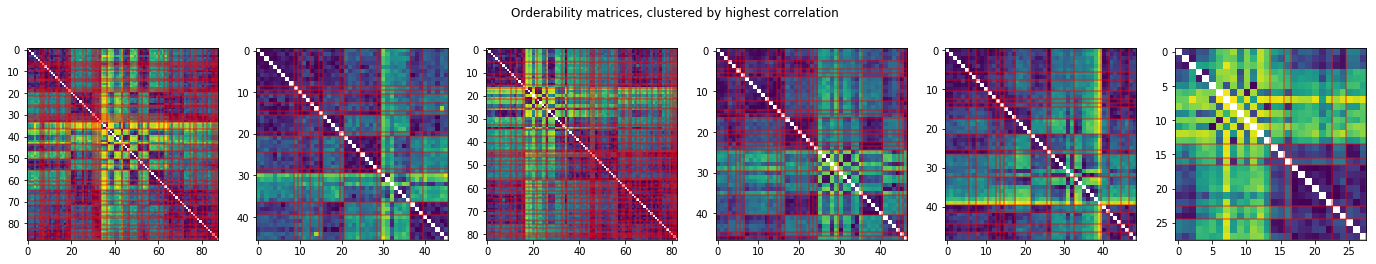

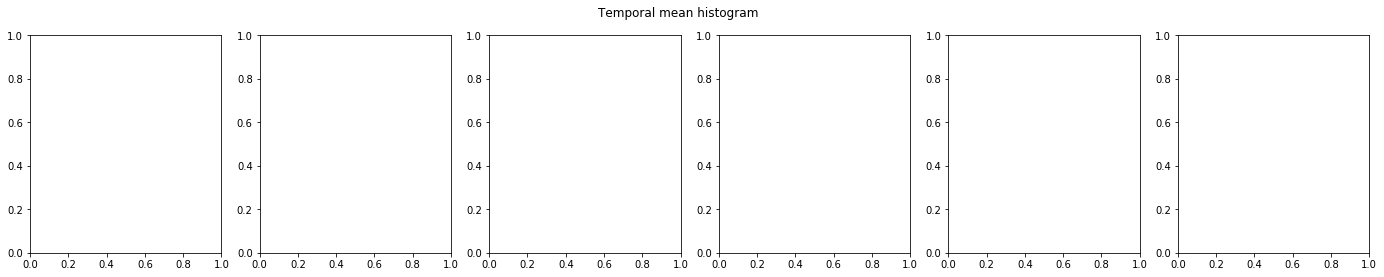

In [9]:
def mat_order_by_idx(M, idx):
    return np.copy(M[idx][:, idx])

def plots_orderability(dataDB, queryDict, selector):    
    nMice = len(dataDB.mice)
    
    figureTitles = {
        "ord"            : "Orderability matrices",
        "ordSort"        : "Orderability matrices, sorted by max orderability",
        "ordCorr"        : "Absolute Correlation between sorted orderability rows",
        "ordCorrClust"   : "Absolute Correlation, sorted by clustering",
        "ordClust"       : "Orderability matrices, clustered by highest correlation",
        "tempMeanHist"   : "Temporal mean histogram",
    }
    
    figs = {k : plt.subplots(ncols=nMice, figsize=(4*nMice, 4)) for k in figureTitles.keys()}
    for key, (fig, ax) in figs.items():
        fig.suptitle(figureTitles[key])
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {**queryDict, **{'mousename' : mousename}}

        ########################
        # Get data
        ########################
        dataBinOrd = metric_by_selector(dataDB, queryDictCond, "ord_binary", "", selector, {})
#         dataTempMu = metric_by_selector(dataDB, queryDictCond, "ord_mean", "rp", selector, {})
        
        ########################
        # Precompute stuff
        ########################
        meanBinOrd1D = np.nanmean(dataBinOrd, axis=0)
        idxSortBinOrd = np.argsort(meanBinOrd1D)[::-1]
        dataBinOrdSorted = mat_order_by_idx(dataBinOrd, idxSortBinOrd)
        
        dataBinOrdSortedZero = np.copy(dataBinOrdSorted)
        np.fill_diagonal(dataBinOrdSortedZero, 0)
        dataBinOrdSortedCorr = np.abs(np.corrcoef(dataBinOrdSortedZero))

        clustering = cluster_dist_matrix(dataBinOrdSortedCorr, 1.5) - 1  # Clusters numbered from 0
#         nCluster = np.max(clustering)
#         clusterMeanOrd = [np.nanmean(dataBinOrdSorted[clustering == iCluster]) for iCluster in range(nCluster)]
        
#         clustering = np.argsort()
        idxClustering = np.argsort(clustering)
        dataBinOrdSortedCorrClust = mat_order_by_idx(dataBinOrdSortedCorr, idxClustering)
        
        dataBinOrdClust = mat_order_by_idx(dataBinOrdSorted, idxClustering)
        
#         print(clustering)
        
        ########################
        # Plot orderability
        ########################
        # TODO: add color bars
        figs["ord"][1][iMouse].imshow(dataBinOrd, vmin=0, vmax=1)
        
        figs["ordSort"][1][iMouse].imshow(dataBinOrdSorted, vmin=0, vmax=1)
        
        figs["ordCorr"][1][iMouse].imshow(dataBinOrdSortedCorr, vmin=0, vmax=1)
        
        figs["ordCorrClust"][1][iMouse].imshow(dataBinOrdSortedCorrClust, vmin=0, vmax=1)
        
        figs["ordClust"][1][iMouse].imshow(dataBinOrdClust, vmin=0, vmax=1)
        
        plots_lib.clustering_plots_chill(figs["ordClust"][1][iMouse], dataBinOrdSorted, clustering)
        
        
        

queryDict = {'datatype' : 'raw'}
plots_orderability(dataDB, queryDict, {"phase" : "Maintenance"})
# plots_orderability(dataDB, queryDict, {"interval" : 8})